In [1]:
# reload magics
%load_ext autoreload
%autoreload 2

## IMPORTS

In [2]:
import colorcet as cc
import logging
import matplotlib.colors as mc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.axes import Axes

from hdbscan import all_points_membership_vectors, HDBSCAN
from umap import UMAP

from copy import deepcopy, copy

from upsetplot import from_memberships, plot, UpSet, from_indicators

from typing import Dict, List, Tuple, Optional

palette = cc.glasbey_hv

# create a palette dictionary that has the same keys as the original palette
palette_dict = {i: mc.to_hex(palette[i]) for i in range(len(palette))} # type: ignore

# add an entry for -1
palette_dict[-1] = '#ffffff'

# set default colour for seaborn heatmaps
sns.set_theme(style = "whitegrid", rc={'figure.figsize':(8,8)}, palette='viridis')


In [3]:
# heatmap parms
heatmap_parms = {
                'cbar': False,
                'square': False,
                'linewidths': 0.5,
                'linecolor': 'black',
                'center': 0.0,
                'vmin': -1,
                'vmax': 1,
                # 'annot': False,
                'fmt': '.2f',
}

# from the data dictionary
site_name_dict = {
                  1: 'LDN',
                  2: 'MTL',
                  3: 'SAN',
                  4: 'RIO',
                  5: 'LUS',
}

# assign consistent styles
site_style = {
              1: 'D',
              2: 'o',
              3: 'P',
              4: 'X',
              5: 's',
}

In [4]:
figdir   = "./OUTPUT/lc-pos-figures"
reportdir = "../lc2-report"
data_dir = "../lc-project-data"

## FUNCTIONS

In [5]:
#===============================================================================
def compare_two_clusters(df, a, b):
#===============================================================================
# a function to compare two clusters - returns the concatenated cluster data for further analysis

    subset_a = df.query(f"cluster == {a}")
    subset_b = df.query(f"cluster == {b}")

    index_a = subset_a.index
    index_b = subset_b.index

    df_a = df.loc[index_a]
    df_b = df.loc[index_b]

    # concatenate
    df_ab = pd.concat([df_a, df_b])

    # cast cluster to int
    df_ab["cluster"] = df_ab["cluster"].astype(int)

    return df_ab


In [6]:
#===============================================================================
def make_centroids(e, lbls):
#===============================================================================

    # assume that lbls is a pandas series
    if isinstance(lbls, pd.Series):
        lbls = lbls.values
    


    # get the centroids of the umap coordinates by cluster
    centroids = pd.DataFrame(e, 
                                columns = ["x", "y"]).assign(cluster = lbls).groupby("cluster").mean()
    return centroids


#===============================================================================
def make_plot_df(embeddings, clusterer, index, sites):
#===============================================================================

    d = pd.DataFrame(embeddings, columns = ["x", "y"], index = index)
    d["Cluster"]             = clusterer.labels_
    d["Cluster Confidence"]  = clusterer.probabilities_


    try:
        d["Most Likely Cluster"] = np.argmax(all_points_membership_vectors(clusterer), axis = 1)
    except (KeyError, AttributeError):
        d["Most Likely Cluster"] = clusterer.labels_


    # EXPT

    d["Site"]                = sites


    return d



In [7]:
#===============================================================================
def plot_clusters(
                    df: pd.DataFrame, 
                    site_name_dict: dict,
                    centroids: Optional[bool] = None, 
                    # centroids: Optional[pd.DataFrame] = None, 
                    title: Optional[str] = None,
                      most_likely: bool = False,
                      size_by_prob: bool = False,
                      ax: Optional[Axes] = None,
                      ):
#===============================================================================

    # plot the embeddings
    # fig, ax = plt.subplots(figsize=(10, 10))

    if ax == None:
        fig, ax = plt.subplots(figsize=(10, 10))
    else:
        fig = None
        ax = ax
        pass


    if most_likely:
        hue = "Most Likely Cluster"
    else:
        hue = "Cluster"

    if size_by_prob:
        size = "Cluster Confidence"
    else:
        size = None

    sns.scatterplot(data = df, 
                    x = "x",
                    y = "y",
                    s = 150,
                    edgecolor = 'black', 
                    hue       = hue,
                    linewidth = 0.5, 
                    palette   = palette_dict,
                    style     = "Site",
                    style_order = site_name_dict.values(),
                    markers = ['o','D', 'P', 'X', 's'],
                    size      = size,
                    # size      = "Cluster Confidence",
                    ax = ax
                        )

    if centroids is not None:
        # plot centroids
        centroids = make_centroids(df[["x", "y"]].values, df["Cluster"])
        plot_centroids(centroids, ax, palette_dict = None)

    # set title
    if title:
        plt.title(title)

    # place the legend outside to the right of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    # turn off axis labels and ticks
    if ax == None:
        plt.xticks([]); plt.yticks([]);
        plt.xlabel(""); plt.ylabel("");

        # make labels larger
        plt.tick_params(axis='both', which='major', labelsize=16)

        # make the legend larger
        plt.setp(ax.get_legend().get_texts(), fontsize='16') # for legend text
        plt.setp(ax.get_legend().get_title(), fontsize='16') # for legend title

    return fig, ax

#===============================================================================
def plot_centroids(centroids, ax, alpha = 1.0, palette_dict = None, fontsize = 24):
#===============================================================================
    # plot the centroids



    for i, centroid in centroids.iterrows():
        if i != -1:

            if palette_dict is not None:
                ec = palette_dict[i]
            else:
                ec = 'w'

            ax.annotate(
                        i,
                        (centroid.x, centroid.y), 
                        ha='center',
                        va='center',
                        bbox=dict(boxstyle="round,pad=0.3", 
                                    fc="k", 
                                    # ec="#ababab",
                                    ec = ec,
                                    # ec="w",
                                    # fc="white", 
                                    # ec="black",
                                    lw=2, 
                                    alpha=alpha,
                                    ),
                        fontsize = fontsize,
                        color = 'white',
                        # make font bold
                        fontweight = "bold",
                        )



In [8]:
#===============================================================================
def make_upset_data(df, 
                    ftrs, 
                    method = "mean", 
                    add_column = None,
                    keep_features = False):
#===============================================================================

    if method not in ["mean", "median"]:
        print(f"Method {method} not supported.")

    else:
        if method == "mean":
            new_df = df[ftrs] > df[ftrs].mean(axis = 0)
        # elif method == "median":
        else:
            new_df = df[ftrs] > df[ftrs].median(axis = 0)

    new_df = new_df[ftrs]
    new_df.rename(columns= {c: f">{c}" for c in ftrs}, inplace = True)

    df2 = pd.concat([df, new_df, add_column], axis = 1) # type: ignore
    if keep_features == True:
        pass
    else:
        df2 = df2.set_index(list(new_df.columns))

    return df2

In [9]:
#===============================================================================
def excursion_plot(d, 
                    method = "mean",
                    grouper = "cluster",
                    style: str = "binary",
                    figsize = (6,64),
                    ax = None,
                    ):
#===============================================================================

    norm = None

    # qq.astype(int)
    if ax == None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        ax = ax


    # find all object columns and drop them
    d = d.select_dtypes(exclude = "object")

    # set the figsize to scale with the number of features
    figsize = (6, d.shape[1] / 5)

    # get the global median for each feature
    global_median = d.median()
    global_mean   = d.mean()

    globals = pd.concat([global_median, global_mean], axis = 1)
    globals.columns = ["Ensemble Median", "Ensemble Mean"]

    globals.drop(grouper, inplace = True)


    # per feature mean and median
    mm_mean   = d.groupby(grouper).mean().T
    mm_median = d.groupby(grouper).median().T

    # which version?
    if method == "mean":
        mm = mm_mean
        selector = "Ensemble Mean"
    elif method == "median":
        mm = mm_median
        selector = "Ensemble Median"
    else:
        print(f"Method {method} not supported.")
        

    if style == "cont":
        # do the basic plot of means or medians
        # colourmap
        cmap = cc.cm.bjy
        # fig, ax = plt.subplots(figsize=figsize)

        # heatmsp
        sns.heatmap(mm, 
                        cmap = cmap, 
                        ax   = ax, 
                        **heatmap_parms, 
                        norm = norm, 
                        annot = True,
                        annot_kws = {"fontsize": 8}
                        )

        plt.title(f"Excursion Plot: Feature {str.title(method)} by Cluster")
        plt.yticks(fontsize = 8);
        qq = None

    else:
        # mm is the mean or median per cluster per feature
        qq = pd.DataFrame(index = mm.index, columns = mm.columns)

        # for each cluster c in mm, 
        for c in mm.columns:
            # for each feature in this cluster, compare to the respective global mean
            for i, v in enumerate(mm[c].values):
                # is this cluster's mean or median greater than 
                # the global ensemble mean or median?
                # this will fill qq with true/false
                qq.loc[qq.index[i],c] = v >  globals.loc[qq.index[i], selector] # type: ignore

        # # qq.astype(int)
        # fig, ax = plt.subplots(figsize=figsize)

        sns.heatmap(qq.astype(int), 
                    cmap = cc.bjy, 
                    ax = ax, 
                    cbar = False, 
                    vmin = -1, 
                    linewidth = 0.5, 
                    square = False, 
                    linecolor = 'k'
                    )

        plt.yticks(fontsize = 8);
        plt.title(f"Excursion Plot: {str.title(grouper)} {str.title(method)} > {selector}")

    return globals, qq

In [10]:
#===============================================================================
def plot_cluster_by_site(src,
                         data,
                         labels,
                        site_name_dict: dict,

                         title: str,
                         tag: str,
                         ):
#===============================================================================

    # make a copy of the source data
    site_g = src.copy()

    # augment with cluster labels
    site_g.loc[data.index, "cluster"] = labels["Cluster"]

    # group and count
    cluster_by_site = site_g.groupby("cluster")["SITE"].value_counts().unstack().T

    # fill missing values
    cluster_by_site = cluster_by_site.fillna(0).astype(int)

    # map SITE values using site-name_dict

    cluster_by_site.index = cluster_by_site.index.map(site_name_dict)



    # rename columns
    cluster_by_site.columns = cluster_by_site.columns.astype(int)
    # cluster_by_site = cluster_by_site.loc[site_name_dict.values()]

    # sort index alphabetically
    

    fig, ax = plt.subplots(figsize=(8,8), layout = "constrained")

    sns.heatmap(cluster_by_site, 
                robust     = True, 
                ax         = ax, 
                annot      = True, 
                fmt        = "d", 
                cmap       = "viridis", 
                square     = True, 
                linewidths = 0.5, 
                linecolor  = "w", 
                cbar       = False)

    # rename axis labels
    plt.xlabel("Cluster")
    plt.ylabel("Site")
    plt.title(title)

    # fn = f"cluster-membership-umap-{tag}.png"
    # p = f"{figdir}/{fn}"

    # plt.savefig(p, dpi = 300, bbox_inches = 'tight')


## LOAD DATA

In [11]:
# load the data from the xlsx file
# df = pd.read_excel('../lc-project-data/features.xlsx')

In [12]:
# datasets are way faster than excel files
from datasets.arrow_dataset import Dataset

# get today's date

import datetime
today = datetime.date.today().strftime("%Y-%m-%d")

# today = "2024-04-30"


# load the dataset from disk
ds_all = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
ds     = Dataset.load_from_disk(f'../lc-project-data/{today}-features.arrow')
# ds_all = Dataset.load_from_disk('../lc-project-data/features.arrow')
# ds     = Dataset.load_from_disk('../lc-project-data/features.arrow')

In [13]:
df_all = ds_all.data.to_pandas()
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 449 entries, sex to __index_level_0__
dtypes: bool(4), float64(389), int64(55), object(1)
memory usage: 19.3+ MB


In [14]:
# convert to pandas dataframe
df = ds.to_pandas()
df.info() # type: ignore

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5664 entries, 0 to 5663
Columns: 449 entries, sex to __index_level_0__
dtypes: bool(4), float64(389), int64(55), object(1)
memory usage: 19.3+ MB


In [15]:
# drop __index_level_0__
df = df.drop(columns = ["__index_level_0__"])

## LC+, LC-, HC

### Select which sets of feaetures to use

In [16]:
tag = 'all'

print(df.shape) # type: ignore

(5664, 448)


In [17]:
LC_pos = df.query('LC_STATUS == "LC_POS"').copy() # type: ignore
LC_neg = df.query('LC_STATUS == "LC_NEG"').copy() # type: ignore 
HC     = df.query('LC_STATUS == "HC"').copy()     # type: ignore

In [18]:
# LC_pos["CD-severity_level___3"]
# # make a heatmap of all of the CD-severity levels
# fig, ax = plt.subplots(figsize=(8,8))

# sns.heatmap(LC_pos[["CD-severity_level___0", "CD-severity_level___1", "CD-severity_level___2", "CD-severity_level___3"]],)
# # severity level is accoerding to PCR
# # what about sites that didn't use PCR? are they all zero by default?
# LC_pos["CD-mode_of_diag"].value_counts()
# sns.heatmap(LC_pos[["CD-mode_of_diag"]])

In [19]:
LC_pos.shape, LC_neg.shape, HC.shape

((2214, 448), (3367, 448), (83, 448))

In [20]:
# drop object columns because we don't need this 
try:
    LC_pos = LC_pos.drop(columns=['LC_STATUS'])
except:
    pass

# drop __index



In [21]:
LC_pos

sex   age  SITE  MED-Analgesics  MED-Anesthetics  MED-Antibacterials  \
0     2.0  30.0     2               0                0                   0   
1     1.0  33.0     2               0                0                   0   
2     2.0  36.0     2               0                0                   0   
3     2.0  50.0     2               0                0                   0   
4     1.0  40.0     2               0                0                   0   
...   ...   ...   ...             ...              ...                 ...   
5659  1.0  48.0     3               0                0                   0   
5660  2.0  42.0     3               0                0                   0   
5661  1.0  23.0     3               0                0                   0   
5662  1.0  71.0     3               0                0                   0   
5663  2.0  58.0     3               0                0                   0   

      MED-Anticonvulsants  MED-Antidepressants  MED-Antifungals  \
0                       0                    0                0   
1                       0                    0                0   
2                       0                    0                0   
3                       0                    0                0   
4                       0                    0                0   
...                   ...                  ...              ...   
5659                    0                    0                0   
5660                    0                    0                0   
5661                    0                    0                0   
5662                    0                    0                0   
5663                    0                    0                0   

      MED-Antimigraine-agents  ...  LABS-IND-troponinihigh  \
0                           0  ...                     0.0   
1                           0  ...                     0.0   
2                           0  ...                     0.0   
3                           0  ...                     0.0   
4                           0  ...                     0.0   
...                       ...  ...                     ...   
5659                        0  ...                     0.0   
5660                        0  ...                     0.0   
5661                        0  ...                     0.0   
5662                        0  ...                     0.0   
5663                        0  ...                     0.0   

      LABS-IND-troponint  LABS-IND-troponinthigh  LABS-IND-urea  LABS-IND-wbc  \
0                    0.0                     0.0            0.0           0.0   
1                    0.0                     0.0            0.0           0.0   
2                    0.0                     0.0            0.0           0.0   
3                    0.0                     0.0            0.0           0.0   
4                    0.0                     0.0            0.0           0.0   
...                  ...                     ...            ...           ...   
5659                 0.0                     0.0            1.0           0.0   
5660                 0.0                     0.0            1.0           1.0   
5661                 0.0                     0.0            0.0           0.0   
5662                 0.0                     0.0            1.0           0.0   
5663                 0.0                     0.0            1.0           1.0   

      SUBST-1  SUBST-2  SUBST-3  SUBST-4  SUBST-5  
0         0.0      0.0      0.0      0.0      0.0  
1         0.0      0.0      0.0      0.0      0.0  
2         0.0      0.0      0.0      0.0      0.0  
3         1.0      0.0      0.0      0.0      0.0  
4         0.0      0.0      0.0      0.0      0.0  
...       ...      ...      ...      ...      ...  
5659      0.0      0.0      1.0      0.0      0.0  
5660      0.0      0.0      0.0      0.0      0.0  
5661      0.0      0.0      1.0      1.0      0.0  
5662      0.0      0.0    

## SITES

In [22]:
# # get the range of indices for each site
# site_ranges = LC_pos.groupby('SITE').apply(lambda x: (x.index.min(), x.index.max())).rename(index = site_name_dict) # type: ignore

# site_ranges
# # site_ranges.sort_values()

In [23]:
LC_pos['SITE'].value_counts()

SITE
2    915
4    651
5    272
3    266
1    110
Name: count, dtype: int64

# CLUSTERING

In [24]:
# clustering
from sklearn.preprocessing import MinMaxScaler

# dim reduction and clustering benefit from scaling
scaler = MinMaxScaler().set_output(transform = "pandas")

### Which features to drop, if any

In [25]:
# a new dataframe, in case we need to manipulate it and retain the original
LC_pos_ = LC_pos.copy()

# drop certain columns, to experiment with effect on clustering

# drop columns that relate to non-covid events
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '___4').columns)
# the foregoing drops medication_received___3 and medication_received___4
# we need to restore them
LC_pos_["CD-medication_received___3"] = LC_pos["CD-medication_received___3"]
LC_pos_["CD-medication_received___4"] = LC_pos["CD-medication_received___4"]
LC_pos_["CD-ventilatory_support_type___3"] = LC_pos["CD-ventilatory_support_type___3"]
LC_pos_["CD-ventilatory_support_type___4"] = LC_pos["CD-ventilatory_support_type___4"]

LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-3').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '-4').columns)

# drop specific columns
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-severity_level').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-mode_of').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-type_of').columns)

# drop medications and substances
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'MED-').columns)
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SUBST-').columns)

# find all column names that start with SYMPT and end with ___1
# these are for the initial covid infection
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'SYMPT.*___1').columns)

# drop all HHX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'HHX').columns)

# drop all VAX
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'VAX').columns)

# drop all CD-covid_test_result
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-covid_test_result').columns)

# drop all LABS-IND*
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'LABS-IND').columns)
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'IMG').columns)

# drop all CD-
# LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = 'CD-').columns)

vitals = ['temperature',
'heart_rate',
'bp_systolic',
'bp_diastolic',
'respiratory_rate',
'o2_saturation',]

# remove any features that contain words inthe vitals list
LC_pos_ = LC_pos_.drop(columns = LC_pos_.filter(regex = '|'.join(vitals)).columns)


print(LC_pos_.shape)

(2214, 246)


In [26]:
for c in LC_pos_.columns:
    print(c)

sex
age
SITE
MED-Analgesics
MED-Anesthetics
MED-Antibacterials
MED-Anticonvulsants
MED-Antidepressants
MED-Antifungals
MED-Antimigraine-agents
MED-Antiparasitics
MED-Antiparkinson-agents
MED-Antipsychotics
MED-Antispasticity-agents
MED-Antivirals
MED-Blood-glucose-regulators
MED-Blood-products
MED-Cardiovascular-agents
MED-Dental-and-oral-agents
MED-Dermatological-agents
MED-Gastrointestinal-agents
MED-Hormonal-agents-(adrenal)
MED-Hormonal-agents-(sex-hormones)
MED-Hormonal-agents-(thyroid)
MED-Hormone-suppressant-(thyroid)
MED-Immunological-agents
MED-Inflammatory-bowel-disease-agents
MED-Metabolic-bone-disease-agents
MED-Ophthalmic-agents
MED-Respiratory-tract-agents
MED-Skeletal-muscle-relaxants
SYMPT-abdominal_pain___2
SYMPT-chest_pain___2
SYMPT-confusion_altered_mental_s___2
SYMPT-cough___2
SYMPT-diarrhea___2
SYMPT-dizziness___2
SYMPT-ear_pain___2
SYMPT-extremity_weakness_or_numb___2
SYMPT-fatigue___2
SYMPT-fever_38_0oc___2
SYMPT-headache___2
SYMPT-hemoptysis_bloody_sputum___2
SY

In [27]:
# drop the dag and SITE columns - these might guide the clustering algorithm to cluster by site

try:
    LC_pos_ = LC_pos_.drop(columns=['LC_STATUS'])
except:
    pass

# always drop the SITE!
X = scaler.fit_transform(LC_pos_.drop(columns=['SITE']))     # type: ignore


# sort X randomly
X = X.sample(frac = 1)

## Use UMAP to visualize the data and cluster

In [28]:
from hdbscan import HDBSCAN, approximate_predict, all_points_membership_vectors
from umap import UMAP

hdb_parms = {
                # min_cluster_size is rouglhy 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': 50, 
                # 'min_samples': 50,
                'prediction_data': True,
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
            }


umap_parms = {
                'n_components': 2,
                'spread':       5.0,
                'random_state': 42,
            }


# instantiate the clustering and dim reduction objects
hdb_umap   = HDBSCAN(**hdb_parms)
umap_      = UMAP(**umap_parms)

### Handling missing values

In [29]:
# the clustering algorithms depend on the data being complete

# X.dropna(inplace = True, axis = 1)

# drop rows that have a nan in any column
X.dropna(inplace = True, axis = 0)

# if we fill with zeroes, then we are assuming that the missing values are zero
# X.fillna(0, inplace = True)

print(X.shape)


(2209, 245)


### EMBED and CLUSTER

In [44]:
# EXPERIMENTAL
# drop rows in X that are referenced by list in idx

X = X.drop(index = idx)

In [45]:
X.shape

(2189, 245)

In [46]:
# sklearn pipelines
import sklearn.cluster as cluster
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE

from hdbscan import HDBSCAN



min_cluster_size = int(np.sqrt(X.shape[0]))

hdb_parms = {
                # min_cluster_size is roughly 
                # sqrt(n) where n is the number of samples
                'min_cluster_size': min_cluster_size, 
                'cluster_selection_method': 'leaf',
                'cluster_selection_epsilon': 0.1,
                # 'cluster_selection_epsilon': 0.5,
            }

umap_parms = {
                'n_components': 2,
                'spread':       1.0,
                'random_state': 42,
            }


# tsne_transformer = FunctionTransformer(TSNE(n_components = 2, 
#                                             random_state = 42, 
#                                             verbose = 1).fit_transform, validate=False)

umap_transformer = UMAP(**umap_parms, verbose = True)

embedding_model = umap_transformer
# embedding_model = tsne_transformer

# instantiate the pipeline
pipe = Pipeline([
                # scale to unit size
                ('scaler', MinMaxScaler()),
                # for embeddings, we can use TSNE or UMAP
                ('embed', embedding_model),
                # the sklearn HDBCSAN implementation does not have all the 
                # methods of the hdbscan package, so we need to use the hdbscan package
                ('cluster', HDBSCAN(**hdb_parms, prediction_data = True)),
                ])

# apply to the feature dataframe
pipe.fit(X)

if isinstance(pipe.steps[1][1], UMAP):
    points   = pipe["embed"].embedding_
elif isinstance(pipe.steps[1][1], FunctionTransformer):
    points   = pipe["embed"].transform(X)
else:
    print(f"Something went wrong - {pipe.steps[1][1]}")


clusters = pipe["cluster"].labels_
probs    = pipe["cluster"].probabilities_
sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # cluster labels are the maximally probable cluster
cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
                           axis = 1)

clusters = cluster_labels

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


UMAP(random_state=42, verbose=True)
Fri May  3 21:27:25 2024 Construct fuzzy simplicial set
Fri May  3 21:27:26 2024 Finding Nearest Neighbors
Fri May  3 21:27:26 2024 Finished Nearest Neighbor Search
Fri May  3 21:27:26 2024 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Fri May  3 21:27:29 2024 Finished embedding


In [47]:
plot_df = pd.DataFrame(points, columns = ["x", "y"], index = X.index)
plot_df["Cluster"]            = clusters
plot_df["Cluster Confidence"] = probs
plot_df["Site"]               = sites

# what fraction of the data is in each cluster?
plot_df["Cluster"].value_counts(normalize = True)*100


Cluster
2    20.831430
5    19.460941
4    16.308817
6    14.481498
3    10.689813
1     9.410690
0     8.816811
Name: proportion, dtype: float64

In [48]:
# X.loc[145].filter(regex = 'SYMPT')
# LC_pos_.loc[145].filter(regex = 'SYMPT')
# # which points have X > 20?
# plot_df.query("x > 20")

# get the indices
idx = plot_df.query("x < 2").index
idx

Index([], dtype='int64')

In [49]:
# where are those points?
plot_df.loc[idx]

Empty DataFrame
Columns: [x, y, Cluster, Cluster Confidence, Site]
Index: []

In [50]:
# read the records from "LC_POSITIVE_RECORD_IDS.csv"

record_ids = pd.read_csv(f"{data_dir}/LC_POSITIVE_RECORD_IDS.csv", header = 0, index_col = 0)

# record_ids

# get the patient record_id that corresponds to idx
record_ids.loc[idx]["record_id"].to_list()
# sns.heatmap(X.loc[idx].filter(regex = 'SYMPT').T, **heatmap_parms
# sns.heatmap(X.sample(20).filter(regex = 'SYMPT').T, **heatmap_parms)

[]

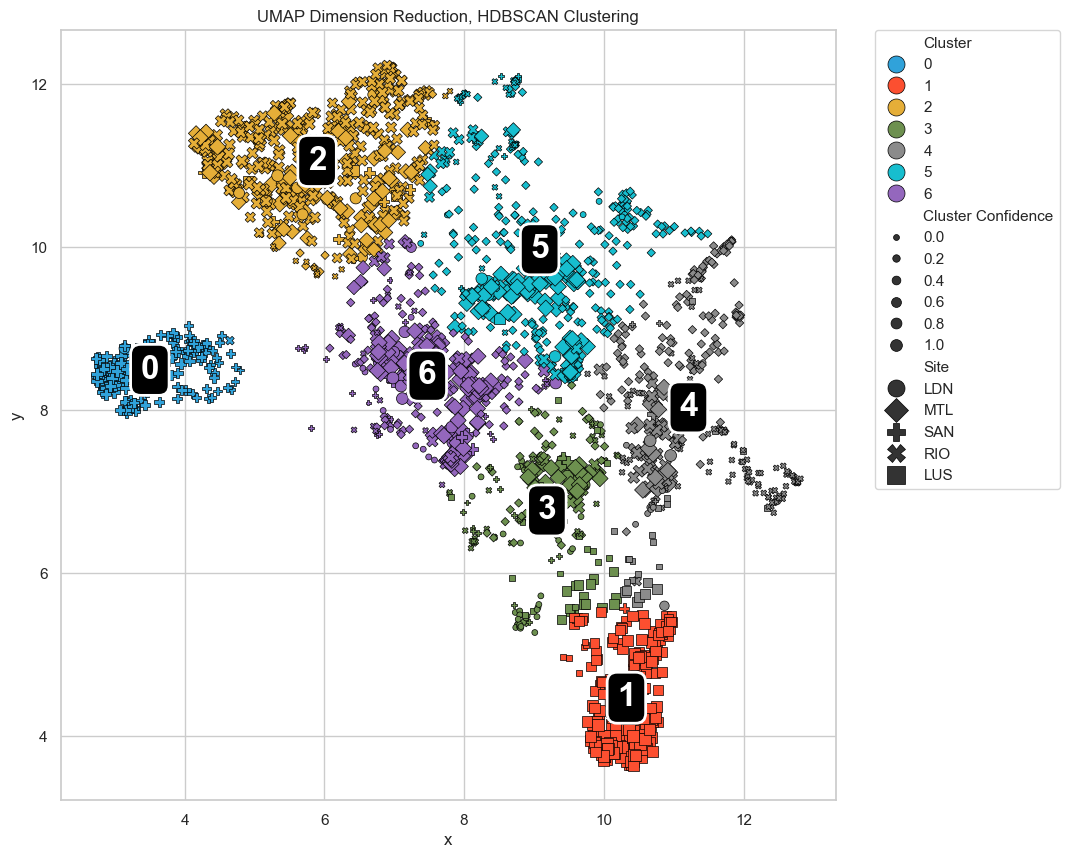

In [51]:
fig_umap, ax_umap = plot_clusters(plot_df, site_name_dict, title = f"UMAP Dimension Reduction, HDBSCAN Clustering", centroids = True, size_by_prob = True, ax = None)

# plt.savefig(f"{figdir}/tsne-hdbscan-umap.png", dpi = 300, bbox_inches = 'tight')

In [52]:
# find the indices of the points that x < 4
idx = plot_df.query("x < 4").index
idx

Index([5109, 5062, 4988, 5184, 4981, 5132, 5033, 5032, 5012, 5150,
       ...
       5085, 5008, 5190, 5054, 5125, 5007, 5101, 5076, 5026, 5651],
      dtype='int64', length=149)

#### Cluster by Site

In [53]:
# count cluster members by site
cluster_by_site = plot_df.groupby("Cluster")["Site"].value_counts().unstack().T.fillna(0).astype(int)

# convert to percent of site
# cluster_by_site = cluster_by_site.div(cluster_by_site.sum(axis = 1), axis = 0)*100

print(cluster_by_site)

# output cluster_by_site to latex
cluster_by_site.to_latex(f"{reportdir}/cluster-by-site.tex")

# plot_cluster_by_site(LC_pos_, X, plot_df, site_name_dict, "HDBSCAN Clustering", tag)

# plt.savefig(f"{figdir}/cluster-membership-tsne-hdbscan.png", dpi = 300, bbox_inches = 'tight')

Cluster    0    1    2   3    4    5    6
Site                                     
LDN        2    0   14  43   16   11   24
LUS        0  205    4  31   25    3    0
MTL        0    0   85  93  157  333  227
RIO        1    0  343  45  152   71   38
SAN      190    1   10  22    7    8   28


#### RFC Model to identify features that differentiate clusters

In [54]:
# use a random forest classifier to find the most important features
from sklearn.ensemble import RandomForestClassifier

# use xgboost
# from xgboost import XGBClassifier
# clf = XGBClassifier(n_estimators = 100, max_depth = 1, random_state = 42)


# instantiate the classifier
# clf = RandomForestClassifier(n_estimators = 1_000, max_depth = 11, random_state = 42)

# use all cores
clf = RandomForestClassifier(n_jobs=-1, 
                            #  n_estimators = 100, 
                            #  class_weight='balanced', 
                             max_depth=7
                             )

# # fit the classifier
# clf.fit(X, cluster_labels)

# # get the 20 most important features
# importances = clf.feature_importances_
# indices     = np.argsort(importances)[::-1][:20]
# features    = X.columns

In [55]:
from boruta_py.boruta import BorutaPy

# instantiate the Boruta feature selector

boruta = BorutaPy(clf, 
                #   n_estimators = 1_000, 
                  n_estimators = 'auto',
                  verbose      = 1, 
                  random_state = 42, 
                  perc         = 100
                  )
boruta.fit(X, cluster_labels)

Iteration: 1 / 100
Iteration: 2 / 100
Iteration: 3 / 100
Iteration: 4 / 100
Iteration: 5 / 100
Iteration: 6 / 100
Iteration: 7 / 100
Iteration: 8 / 100
Iteration: 9 / 100
Iteration: 10 / 100
Iteration: 11 / 100
Iteration: 12 / 100
Iteration: 13 / 100
Iteration: 14 / 100
Iteration: 15 / 100
Iteration: 16 / 100
Iteration: 17 / 100
Iteration: 18 / 100
Iteration: 19 / 100
Iteration: 20 / 100
Iteration: 21 / 100
Iteration: 22 / 100
Iteration: 23 / 100
Iteration: 24 / 100
Iteration: 25 / 100
Iteration: 26 / 100
Iteration: 27 / 100
Iteration: 28 / 100
Iteration: 29 / 100
Iteration: 30 / 100
Iteration: 31 / 100
Iteration: 32 / 100


BorutaPy finished running.

Iteration: 	33 / 100
Confirmed: 	35
Tentative: 	0
Rejected: 	210


BorutaPy(estimator=RandomForestClassifier(max_depth=7, n_estimators=121,
                                          n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x15C3E0940),
         n_estimators='auto', random_state=RandomState(MT19937) at 0x15C3E0940,
         verbose=1)

In [56]:
# make a subset of the data with the important features and 
# fit a classifier on it, using the cluster labels as the target
important_features = X.columns[boruta.support_]
clf.fit(X[important_features], cluster_labels)


RandomForestClassifier(max_depth=7, n_estimators=121, n_jobs=-1,
                       random_state=RandomState(MT19937) at 0x15C3E0940)

In [57]:
# # make a table of features and their importances from the classifier
# fi_df = pd.DataFrame(clf.feature_importances_, index = clf.feature_names_in_, columns = ["Importance"])

# # make a table of all of the features and their rankings
# fff = pd.DataFrame({
#                         # "Feature": features, 
#                         "Feature": X.columns, 
#                         "Ranking": boruta.ranking_, 
#                         "Importance":boruta.support_, })


# # fill fff with the feature importances
# # start with zero
# fff["FI"] = 0.0

# # now fill in the numeric values for the important features
# for i, f in fff.iterrows():
#     if f["Importance"] == True:
#         # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
#         fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# # sort by FI
# fff.sort_values(by = "FI", ascending = False, inplace = True)

In [58]:
# make a dataframe of the important features
dd = pd.DataFrame(clf.feature_importances_, 
                  index = important_features, 
                  columns = ["Importance"]).sort_values("Importance", ascending = False)

dd.reset_index(inplace = True)
dd.rename(columns = {"index": "Feature"}, inplace = True)

# select only the top20 features
features20 = dd[:20].copy()

# rename the features in features20:
features20["Feature"] = features20["Feature"].str.replace("CD-type_of_care___2", "Care: Non-ICU")

# medication received
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___1", "Treated with Steroids")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___2", "Treated with Remdesivir")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___3", "Treated with Anticoagulant")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___4", "Treated with Colchicine")
features20["Feature"] = features20["Feature"].str.replace("CD-medication_received___5", "Treated with Antibiotics")

# rename the features in features20:
features20["Feature"] = features20["Feature"].str.replace("MED-", "")
features20["Feature"] = features20["Feature"].str.replace("CD-", "")
features20["Feature"] = features20["Feature"].str.replace("SYMPT-", "").str.split("___").str[0]

# type of care
features20["Feature"] = features20["Feature"].str.replace("fever_38_0oc", "Fever > 38.0 °C")

# replace underscores with spaces
features20["Feature"] = features20["Feature"].str.replace("_", " ")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


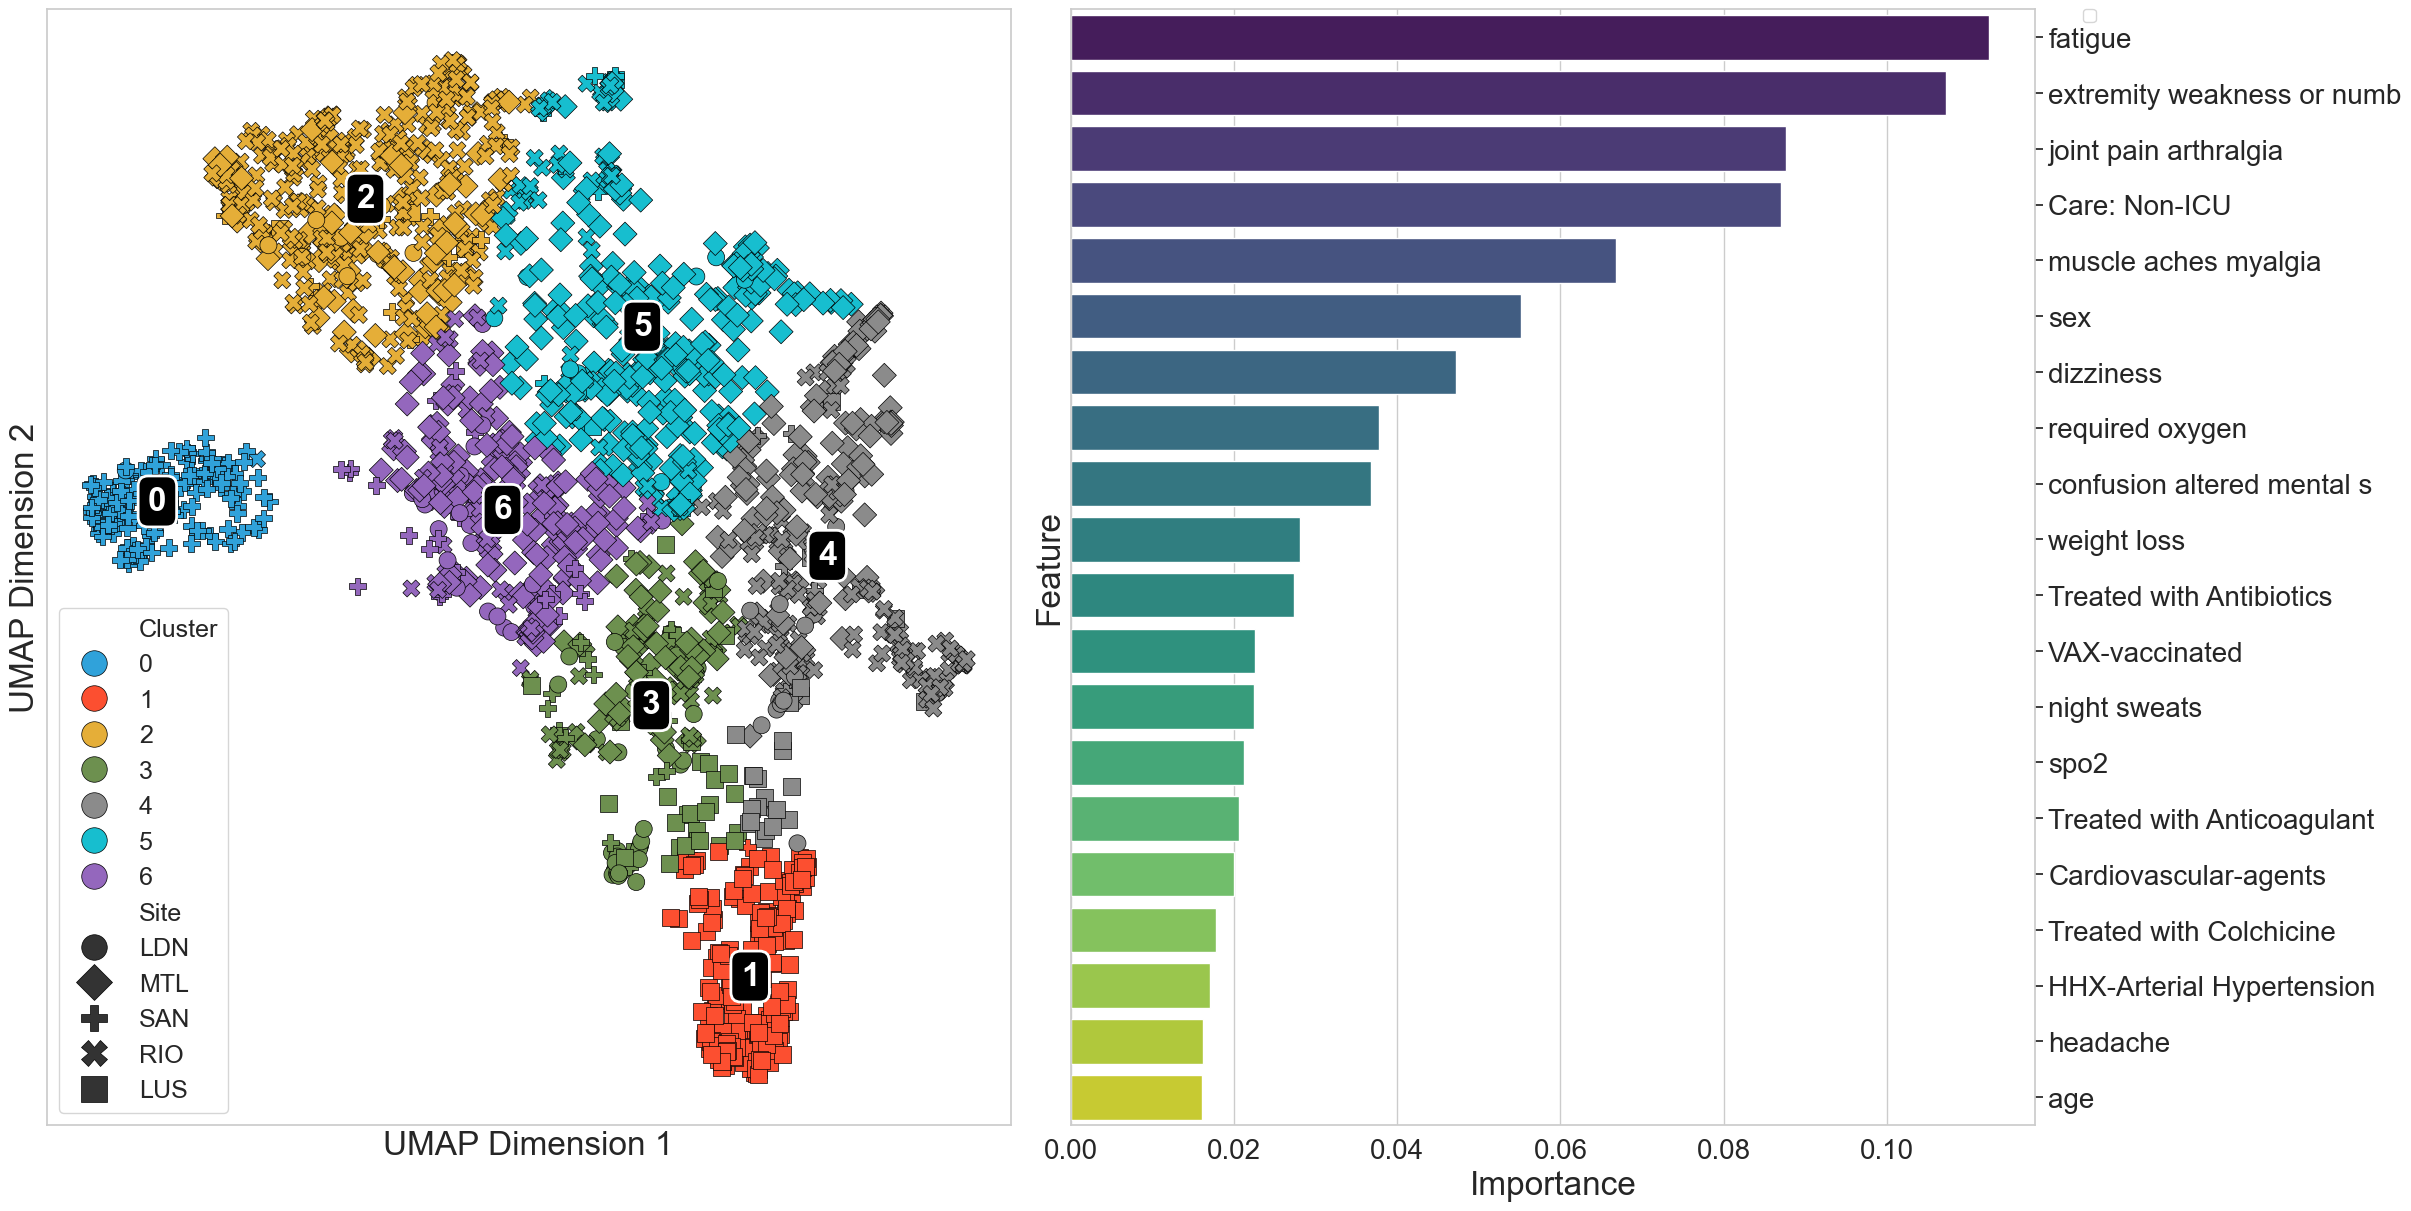

In [59]:
# make a 2x1 plot
fig_2up, ax = plt.subplots(1,2, figsize=(24,12), layout = "constrained")

FONTSIZE = 24

# first, plot the umap clusters
plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = ax[0])

# second, plot the feature importances
sns.barplot(
                y       = features20["Feature"], 
                x       = features20["Importance"],
                palette = "viridis", 
                hue     = features20["Feature"],
                # orient = "h",
                ax = ax[1]
                )


# on the umap plot, ax[0]
# turn off axis labels and ticks on ax[0]
ax[0].set_xticks([]); ax[0].set_yticks([]);
ax[0].set_xlabel("UMAP Dimension 1", fontsize = FONTSIZE); 
ax[0].set_ylabel("UMAP Dimension 2", fontsize = FONTSIZE);
# scale up the markers in ax[0] legend
ax[0].legend(loc='best',markerscale=1.5, fontsize = FONTSIZE-6)

# on the bar plot, ax[1]
# make the x ticks and label larger
ax[1].tick_params(axis='both', which='major', labelsize=FONTSIZE-4)
ax[1].set_xlabel("Importance", fontsize = FONTSIZE)
ax[1].set_ylabel("Feature", fontsize = FONTSIZE)

# put yaxis labels inside the frame
ax[1].yaxis.tick_right()


# plt.savefig(f"{figdir}/feature-importances.png", dpi = 300, bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


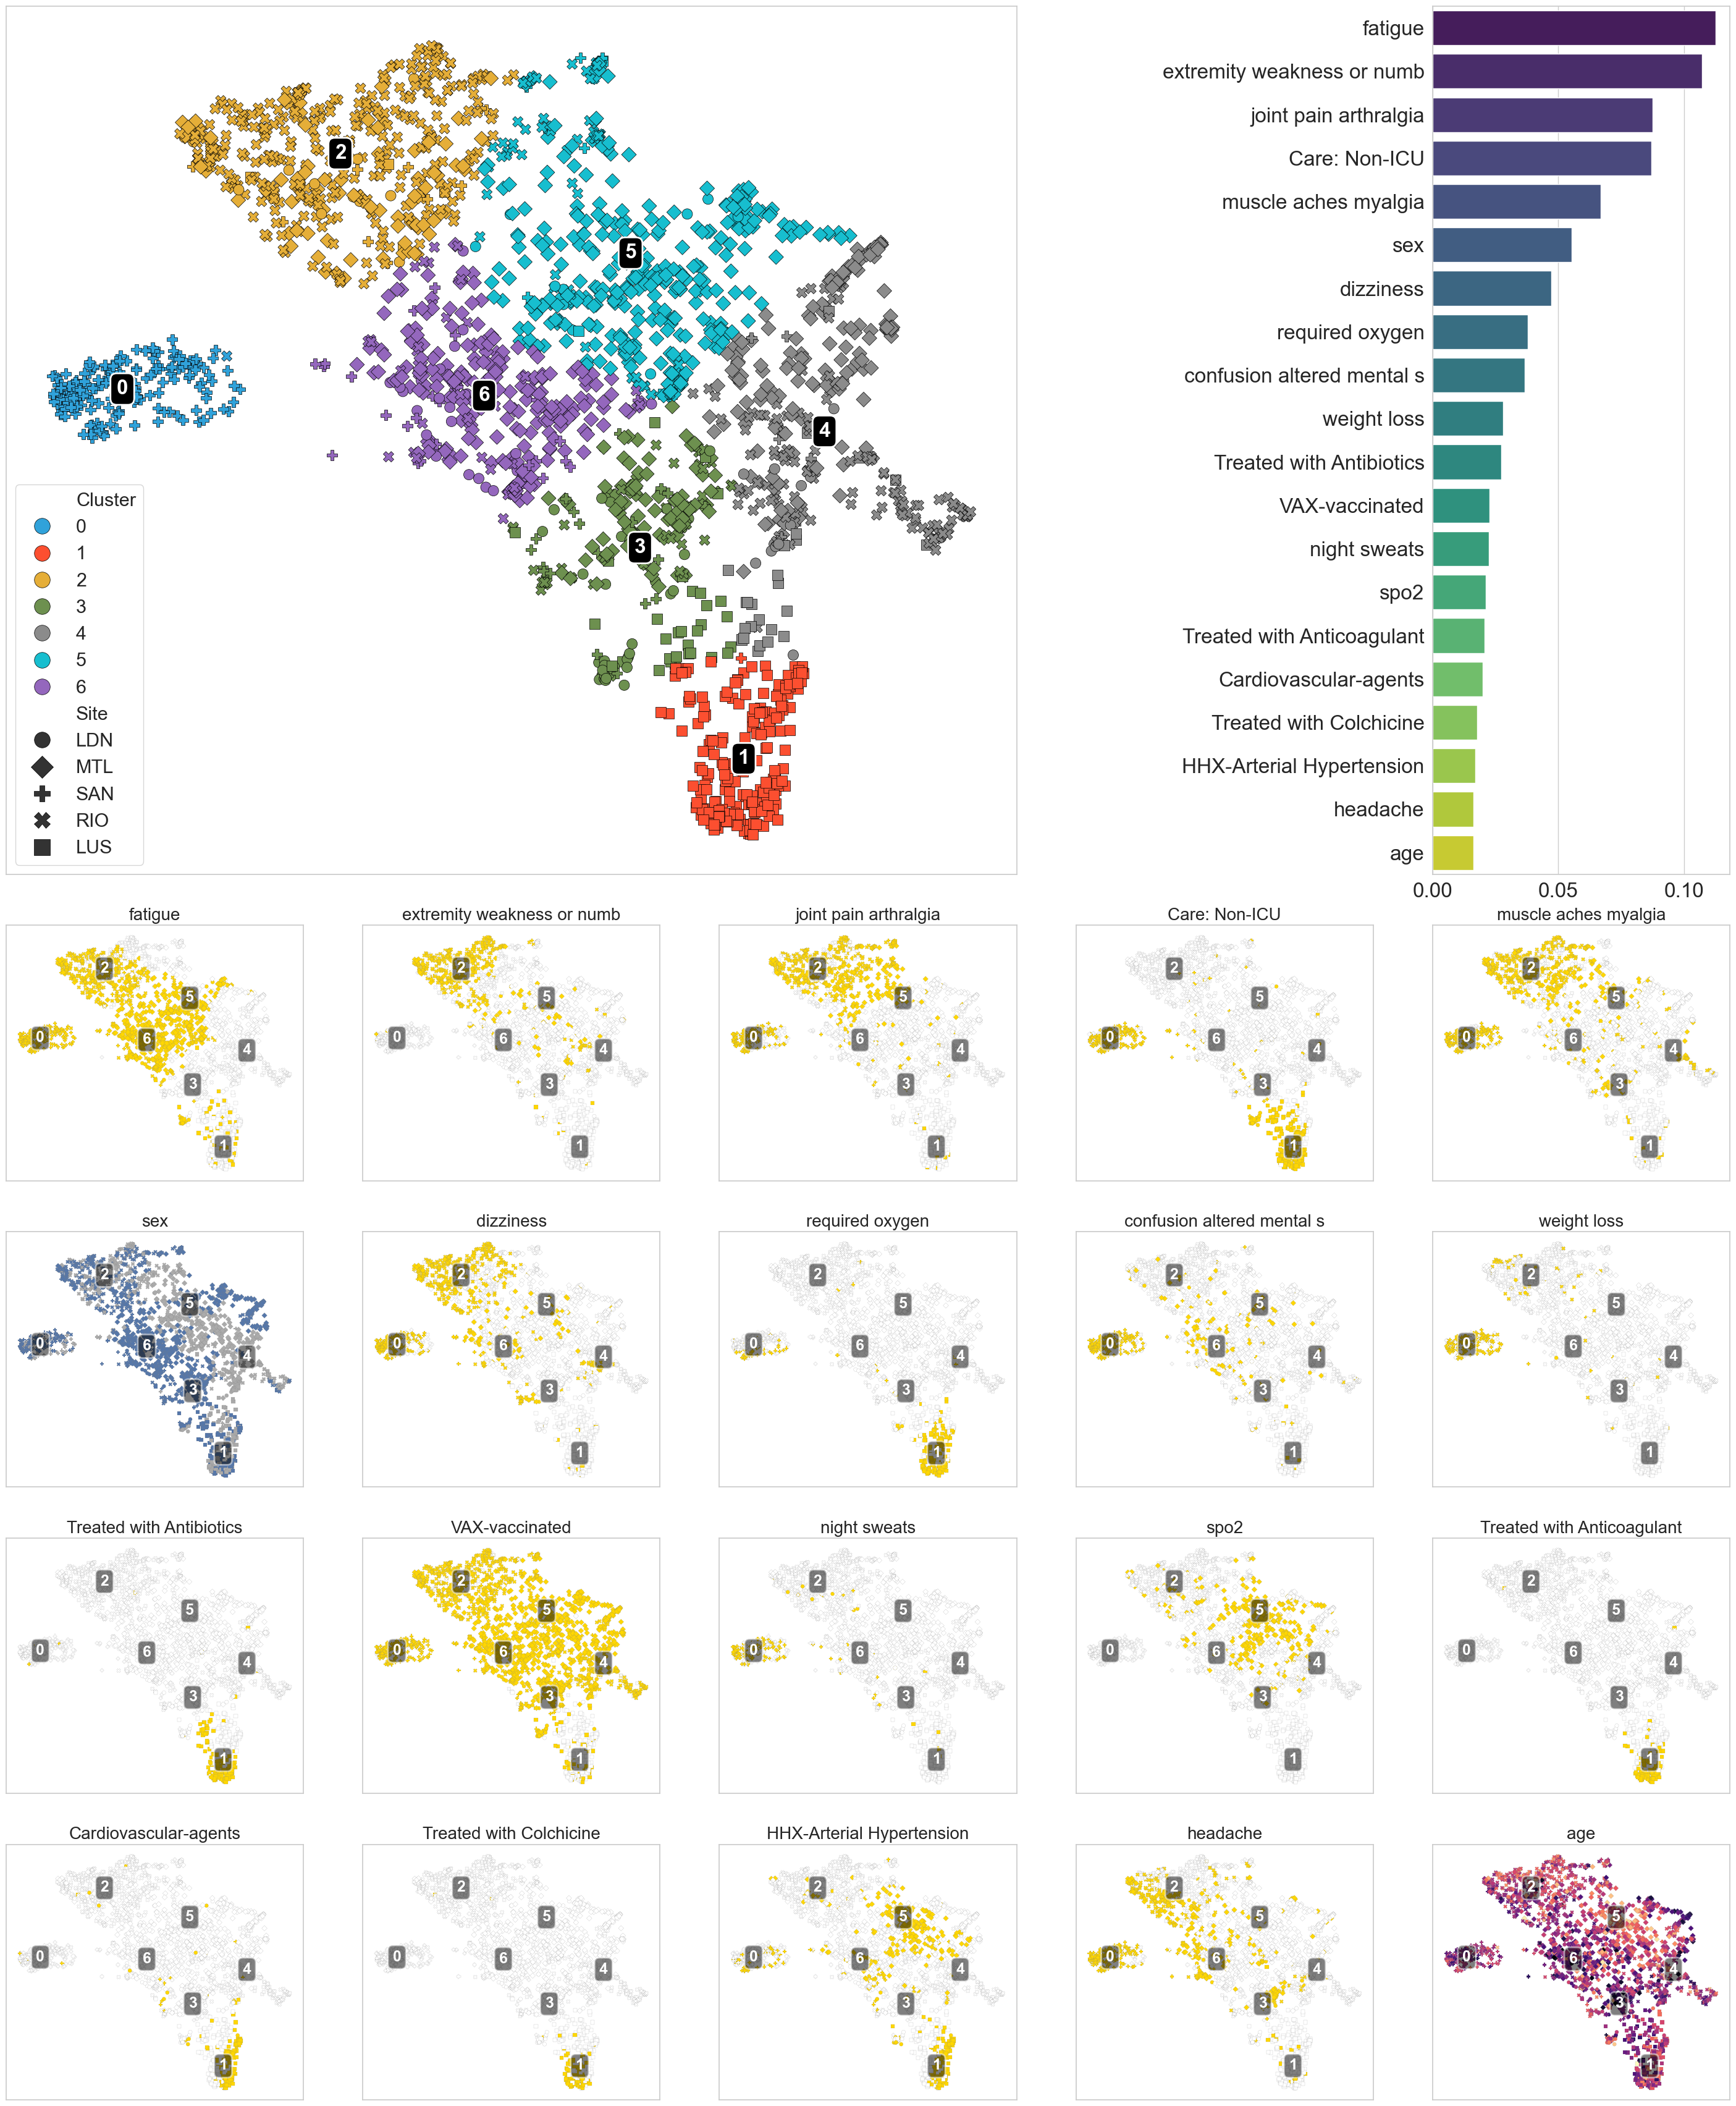

In [60]:

outer_nested_mosaic = [
    # ["umap", "umap", "umap","bars", "bars"],
    # ["umap", "umap", "umap","bars", "bars"],
    # ["umap", "umap", "umap","bars", "bars"],
    ["umap", "umap", "umap","X", "bars"],
    ["umap", "umap", "umap","X", "bars"],
    ["umap", "umap", "umap","X", "bars"],
    # ["X", "X", "X","X", "X"],
    ["bottom1", "bottom2", "bottom3","bottom4", "bottom5"],
    ["bottom6", "bottom7", "bottom8","bottom9", "bottom10"],
    ["bottom11", "bottom12", "bottom13","bottom14", "bottom15"],
    ["bottom16", "bottom17", "bottom18","bottom19", "bottom20"],
]






# lower rows
lower_rows = [f"bottom{i}" for i in range(1,11)]

import matplotlib.transforms as mtransforms

# axd = plt.figure(figsize = (36,36)).subplot_mosaic(
#     outer_nested_mosaic, empty_sentinel="X"
# )


fig, axd = plt.subplot_mosaic(outer_nested_mosaic, figsize = (36,44), empty_sentinel="X")

plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axd["umap"])

axd["umap"].set_xticks([]); axd["umap"].set_yticks([]);
# turn off axis labels
axd["umap"].set_xlabel(""); axd["umap"].set_ylabel("")

# make the legend larger
axd["umap"].legend(loc='best',markerscale=1.5, fontsize = FONTSIZE-2)

# adjust bottom spacing
# plt.subplots_adjust(bottom=0.1)
# plt.subplots_adjust(top=0.9)

# second, plot the feature importances
sns.barplot(
                y       = features20["Feature"], 
                x       = features20["Importance"],
                palette = "viridis", 
                hue     = features20["Feature"],
                # orient = "h",
                ax = axd["bars"]
                )

# make the x ticks and label larger
axd["bars"].tick_params(axis='both', which='major', labelsize=FONTSIZE)


# turn off the labels
axd["bars"].set_xlabel(""); axd["bars"].set_ylabel("")
# axd["bars"].yaxis.tick_right()

# set yaxis tick labels to the right of the y-axis spine





# multiplots
sympt_dict = {0:"Absent", 1:"Present"}
int_feat = dd["Feature"][:20]
# int_feat = features20["Feature"]


centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# plot the features by cluster
for i, f in enumerate(int_feat):

    the_ax = axd[f"bottom{i+1}"]

    if f == "age":
        plot_df[f] = X[f]
        palette = 'magma'
        # palette = cc.bwy[:2]
        hue_order = None

    elif f == "sex":
        plot_df[f] = X[f].map({0: "Male", 1:"Female"})
        palette = ["#ababab", "#5577aa"]
        hue_order = ["Male", "Female"]

    else:
        plot_df[f] = X[f].map(sympt_dict)
        palette = ['white', 'gold']
        hue_order = ["Absent", "Present"]


    sns.scatterplot(data = plot_df, 
                    x         = "x", 
                    y         = "y", 
                    # hue = "Dyspnea", 
                    # hue_order = ["None", "Onset", "Now", "Both"],
                    hue       = f,
                    palette   = palette, 
                    hue_order = hue_order,
                    # palette   = cc.glasbey_hv[:2], 
                    style     = "Site", 
                    style_order = site_name_dict.values(), 
                    markers   = ['o','D', 'P', 'X', 's'], 
                    edgecolor = 'gray', 
                    # linewidth = 0.0, 
                    linewidth = 0.125, 
                    s         = 20, 
                    # alpha     = 0.75,
                    ax        = the_ax
                    )

    plot_centroids(centroids, the_ax, alpha = 0.5, fontsize = 18)

    # turn off the ticks on the ax
    the_ax.set_xticks([]); the_ax.set_yticks([])
    the_ax.set_xlabel(""); the_ax.set_ylabel("")

    # set axis title
    the_ax.set_title(features20["Feature"][i], fontsize = FONTSIZE-4)

    # set title size smaller
    # the_ax.title.set_size(FONTSIZE)

    # turn off the legnd on the ax
    the_ax.legend().remove()

    # # set aspect ratio to 1
    # # the_ax.set_aspect('equal')

    # # turn off grid and ticks
    # plt.xticks([]); plt.yticks([])
    # plt.xlabel(""); plt.ylabel("")

    # # turn off legend
    # plt.legend().remove()

# for label, ax in axd.items():
#     # label physical distance in and down:
#     trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
#     ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
#             fontsize=FONTSIZE, verticalalignment='top', 
#             bbox=dict(facecolor='0.7', edgecolor='none', pad=3.0))

# plt.show()

# # plt.suptitle(f"{f} by Cluster")
# plt.savefig(f"{figdir}/cluster-figure-ensemble.png", dpi = 300, bbox_inches = 'tight')

plt.savefig(f"{figdir}/cluster-figure-ensemble.pdf", dpi = 300, bbox_inches = 'tight')
plt.show()
plt.close()

In [62]:
# fig = plt.figure(tight_layout=False, figsize=(24,36))

# import matplotlib.gridspec as gridspec

# gs = gridspec.GridSpec(5,5, figure = fig)

# ax1 = fig.add_subplot(gs[0, :3])
# ax2 = fig.add_subplot(gs[0, 3:])

# axl = list()

# for a in range(4):
#     for b in range(5):
#         ax = fig.add_subplot(gs[a+1, b])
#         axl.append(ax)



# # second, plot the feature importances
# sns.barplot(
#                 y       = features20["Feature"], 
#                 x       = features20["Importance"],
#                 palette = "viridis", 
#                 hue     = features20["Feature"],
#                 # orient = "h",
#                 ax = ax2
#                 )


# # ax1 = fig.add_subplot(gs[1, 0])
# plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = ax1)
# ax1.set_xticks([]); ax1.set_yticks([]);





# # multiplots
# sympt_dict = {0:"Absent", 1:"Present"}
# int_feat = dd["Feature"][:20]
# # int_feat = features20["Feature"]


# centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# # plot the features by cluster
# for i, f in enumerate(int_feat):

#     the_ax = axl[i]

#     if f == "age":
#         plot_df[f] = X[f]
#         palette = 'magma'
#         # palette = cc.bwy[:2]
#         hue_order = None

#     elif f == "sex":
#         plot_df[f] = X[f].map({0: "Male", 1:"Female"})
#         palette = ["#ababab", "#5577aa"]
#         hue_order = ["Male", "Female"]

#     else:
#         plot_df[f] = X[f].map(sympt_dict)
#         palette = ['white', 'gold']
#         hue_order = ["Absent", "Present"]


#     sns.scatterplot(data = plot_df, 
#                     x         = "x", 
#                     y         = "y", 
#                     # hue = "Dyspnea", 
#                     # hue_order = ["None", "Onset", "Now", "Both"],
#                     hue       = f,
#                     palette   = palette, 
#                     hue_order = hue_order,
#                     # palette   = cc.glasbey_hv[:2], 
#                     style     = "Site", 
#                     style_order = site_name_dict.values(), 
#                     markers   = ['o','D', 'P', 'X', 's'], 
#                     edgecolor = 'gray', 
#                     # linewidth = 0.0, 
#                     linewidth = 0.125, 
#                     s         = 20, 
#                     # alpha     = 0.75,
#                     ax        = the_ax
#                     )

#     plot_centroids(centroids, the_ax, alpha = 0.5, fontsize = 18)

#     # turn off the ticks on the ax
#     the_ax.set_xticks([]); the_ax.set_yticks([])
#     the_ax.set_xlabel(""); the_ax.set_ylabel("")

#     # set axis title
#     the_ax.set_title(features20["Feature"][i], fontsize = FONTSIZE-4)

#     # set title size smaller
#     # the_ax.title.set_size(FONTSIZE)

#     # turn off the legnd on the ax
#     the_ax.legend().remove()




# # fig.align_ylabels()

# # # move the legend inside the plot on ax1
# # ax1.legend(loc='upper right',markerscale=1.5, fontsize = FONTSIZE-6)

# plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

0 SYMPT-fatigue___2
1 SYMPT-extremity_weakness_or_numb___2
2 SYMPT-joint_pain_arthralgia___2
3 CD-type_of_care___2
4 SYMPT-muscle_aches_myalgia___2
5 sex
6 SYMPT-dizziness___2
7 CD-required_oxygen
8 SYMPT-confusion_altered_mental_s___2
9 SYMPT-weight_loss___2
10 CD-medication_received___5
11 VAX-vaccinated
12 SYMPT-night_sweats___2


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

13 CD-spo2
14 CD-medication_received___3
15 MED-Cardiovascular-agents
16 CD-medication_received___4
17 HHX-Arterial Hypertension
18 SYMPT-headache___2
19 age


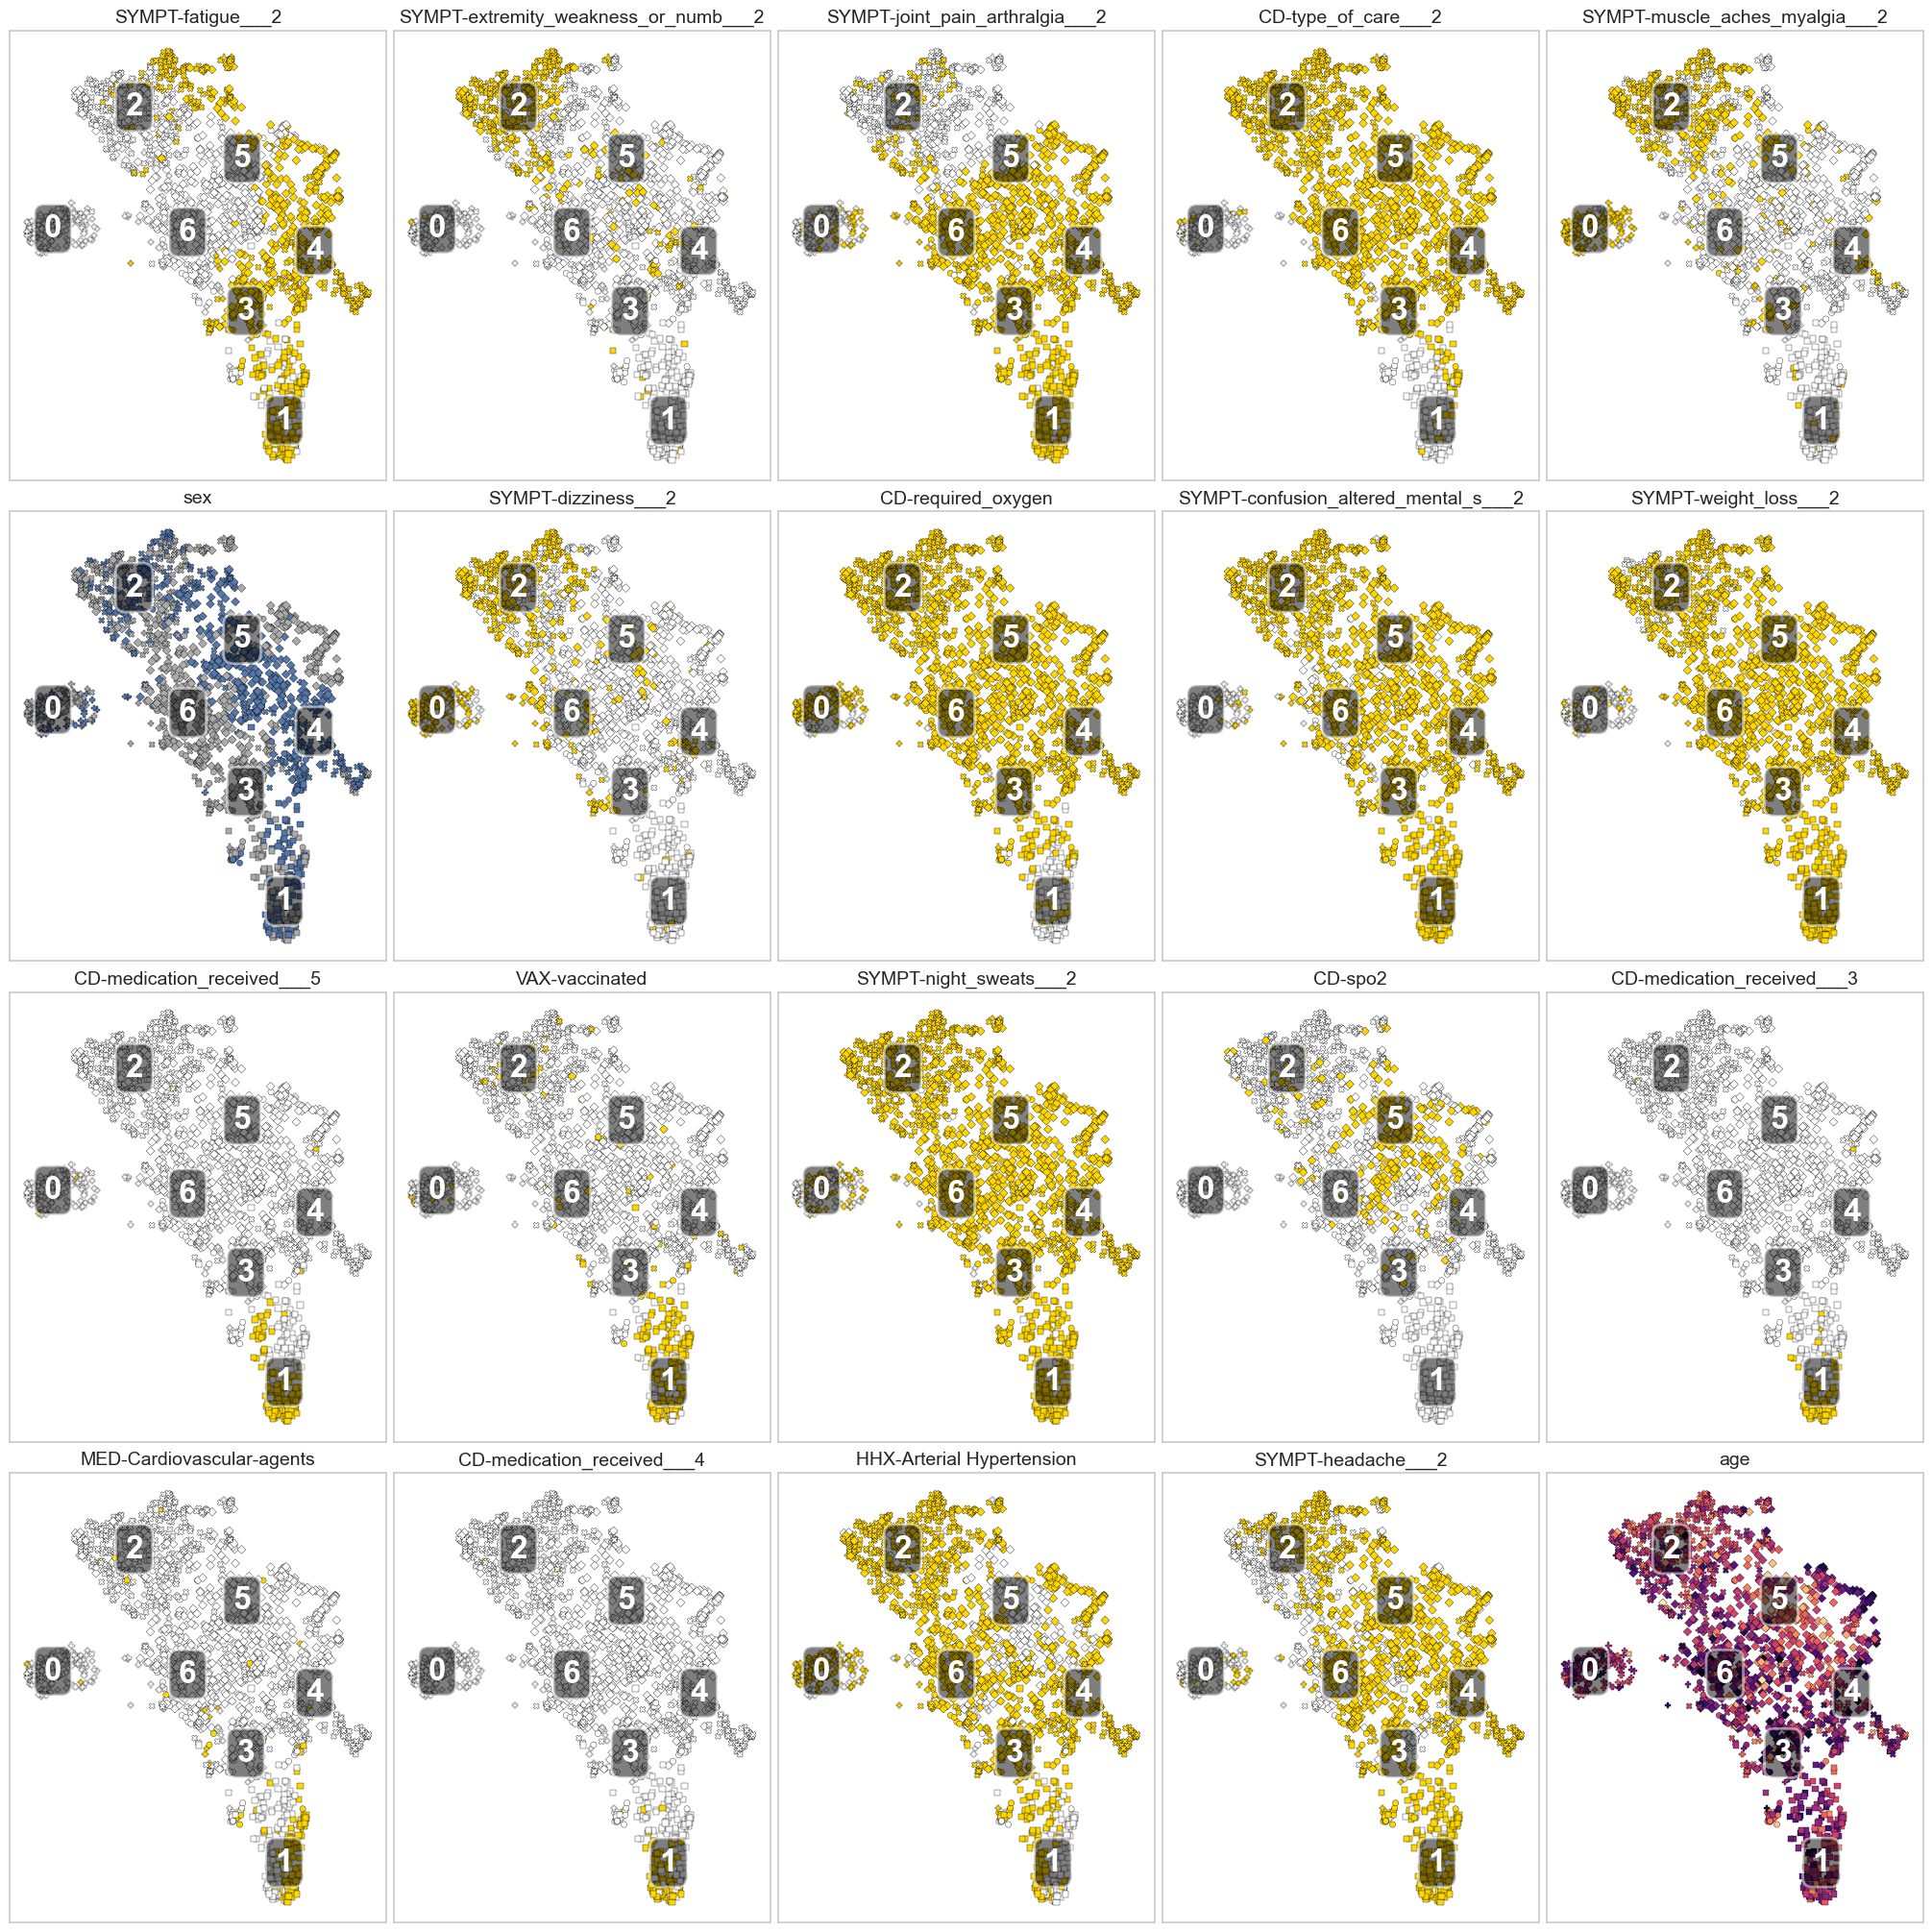

In [76]:
sympt_dict = {0:"Absent", 1:"Present"}
int_feat = dd["Feature"][:20]
# int_feat = features20["Feature"]

# make an array of 10 figures

fig3, ax = plt.subplots(4, 5, figsize=(20, 20), sharex = True, sharey = True, layout = "constrained")

ax  = ax.flatten()

centroids = make_centroids(plot_df[["x", "y"]].values, plot_df["Cluster"])

# plot the features by cluster
for i, f in enumerate(int_feat):

    the_ax = ax[i]

    print(i,f)

    if f == "age":
        plot_df[f] = X[f]
        palette = 'magma'
        # palette = cc.bwy[:2]
        hue_order = None

    elif f == "sex":
        plot_df[f] = X[f].map({0: "Male", 1:"Female"})
        palette = ["#ababab", "#5577aa"]
        hue_order = ["Male", "Female"]

    else:
        plot_df[f] = X[f].map(sympt_dict)
        palette = ['white', 'gold']
        hue_order = ["Absent", "Present"]


    sns.scatterplot(data = plot_df, 
                    x         = "x", 
                    y         = "y", 
                    hue       = f,
                    palette   = palette, 
                    # palette   = cc.glasbey_hv[:2], 
                    style     = "Site", 
                    style_order = site_name_dict.values(), 
                    markers   = ['o','D', 'P', 'X', 's'], 
                    edgecolor = 'k', 
                    linewidth = 0.25, 
                    s         = 20, 
                    # alpha     = 0.75,
                    ax        = the_ax
                    )

    plot_centroids(centroids, the_ax, alpha = 0.5)

    # turn off the ticks on the ax
    the_ax.set_xticks([]); the_ax.set_yticks([])
    the_ax.set_xlabel(""); the_ax.set_ylabel("")

    # set axis title
    the_ax.set_title(f)

    # set title size smaller
    the_ax.title.set_size(14)

    # turn off the legnd on the ax
    the_ax.legend().remove()

    # set aspect ratio to 1
    # the_ax.set_aspect('equal')

    # turn off grid and ticks
    plt.xticks([]); plt.yticks([])
    plt.xlabel(""); plt.ylabel("")

    # turn off legend
    plt.legend().remove()

    # plt.title(f"{f} by Cluster")
    # plt.savefig(f"{figdir}/{f}.png", dpi = 300, bbox_inches = 'tight')



plt.show()
# plt.suptitle("Features by Cluster")
# plt.savefig(f"{figdir}/features-by-cluster.png", dpi = 300, bbox_inches = 'tight')

### Excursion Plots

In [64]:
# make a table of features and their importances from the classifier
fi_df = pd.DataFrame(clf.feature_importances_, index = clf.feature_names_in_, columns = ["Importance"])

# make a table of all of the features and their rankings
fff = pd.DataFrame({
                        # "Feature": features, 
                        "Feature": X.columns, 
                        "Ranking": boruta.ranking_, 
                        "Importance":boruta.support_, })


# fill fff with the feature importances
# start with zero
fff["FI"] = 0.0

# now fill in the numeric values for the important features
for i, f in fff.iterrows():
    if f["Importance"] == True:
        # print(i,f["Feature"], fi_df.loc[f["Feature"]]["Importance"])
        fff.loc[i, "FI"] = fi_df.loc[f["Feature"]]["Importance"]

# sort by FI
fff.sort_values(by = "FI", ascending = False, inplace = True)

In [67]:
# save the cluster labels to a copy of the original dataframe
A = X.copy()
M = X.copy()

# sosrt columns in the order set in fff
M = M[fff["Feature"]]

# augment with cluster labels
A["cluster"] = cluster_labels
M["cluster"] = cluster_labels


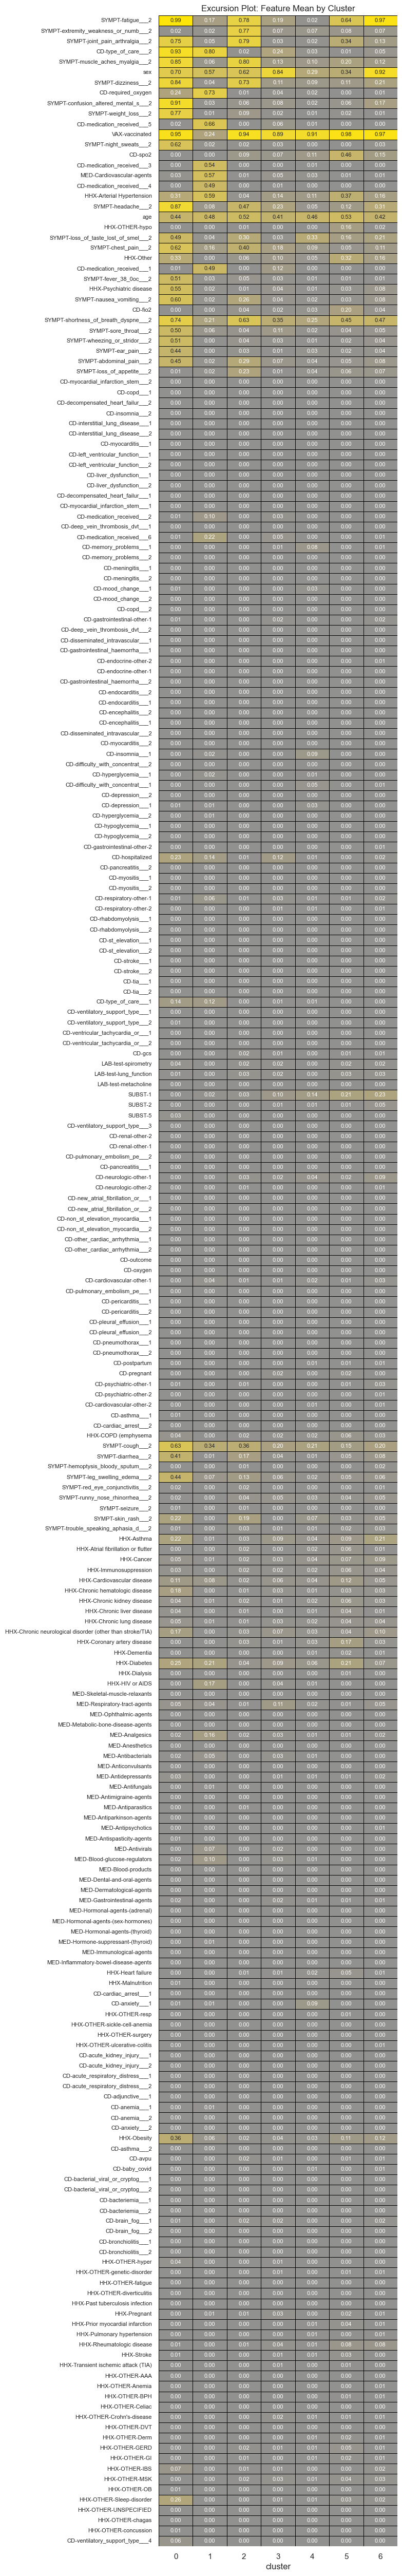

In [68]:
g, q = excursion_plot(M, method = "mean", style = "cont")

fn = f"mean-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

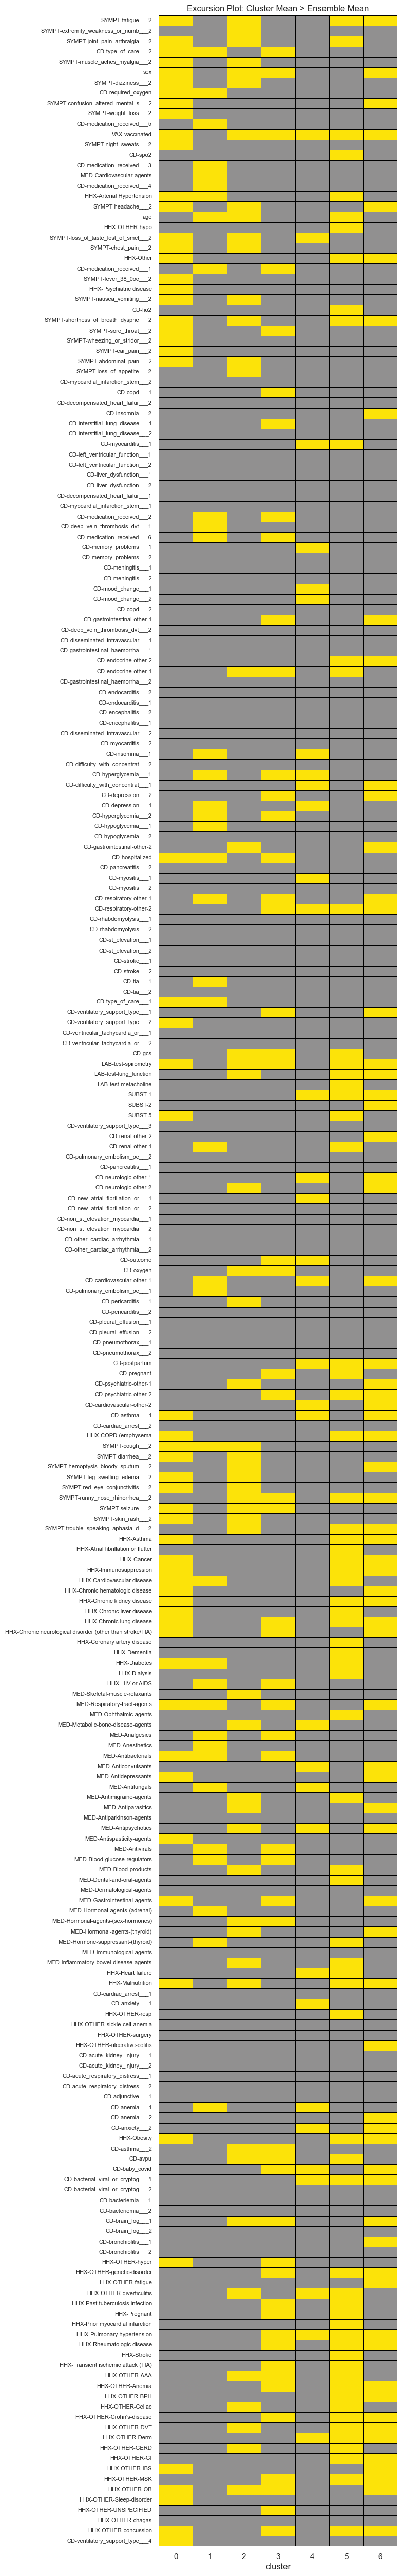

In [69]:
g,q = excursion_plot(M, method = "mean")


fn = f"binary-feature-values-umap-{tag}.png"
p = f"{figdir}/{fn}"

plt.savefig(p, dpi = 300, bbox_inches = 'tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, '')

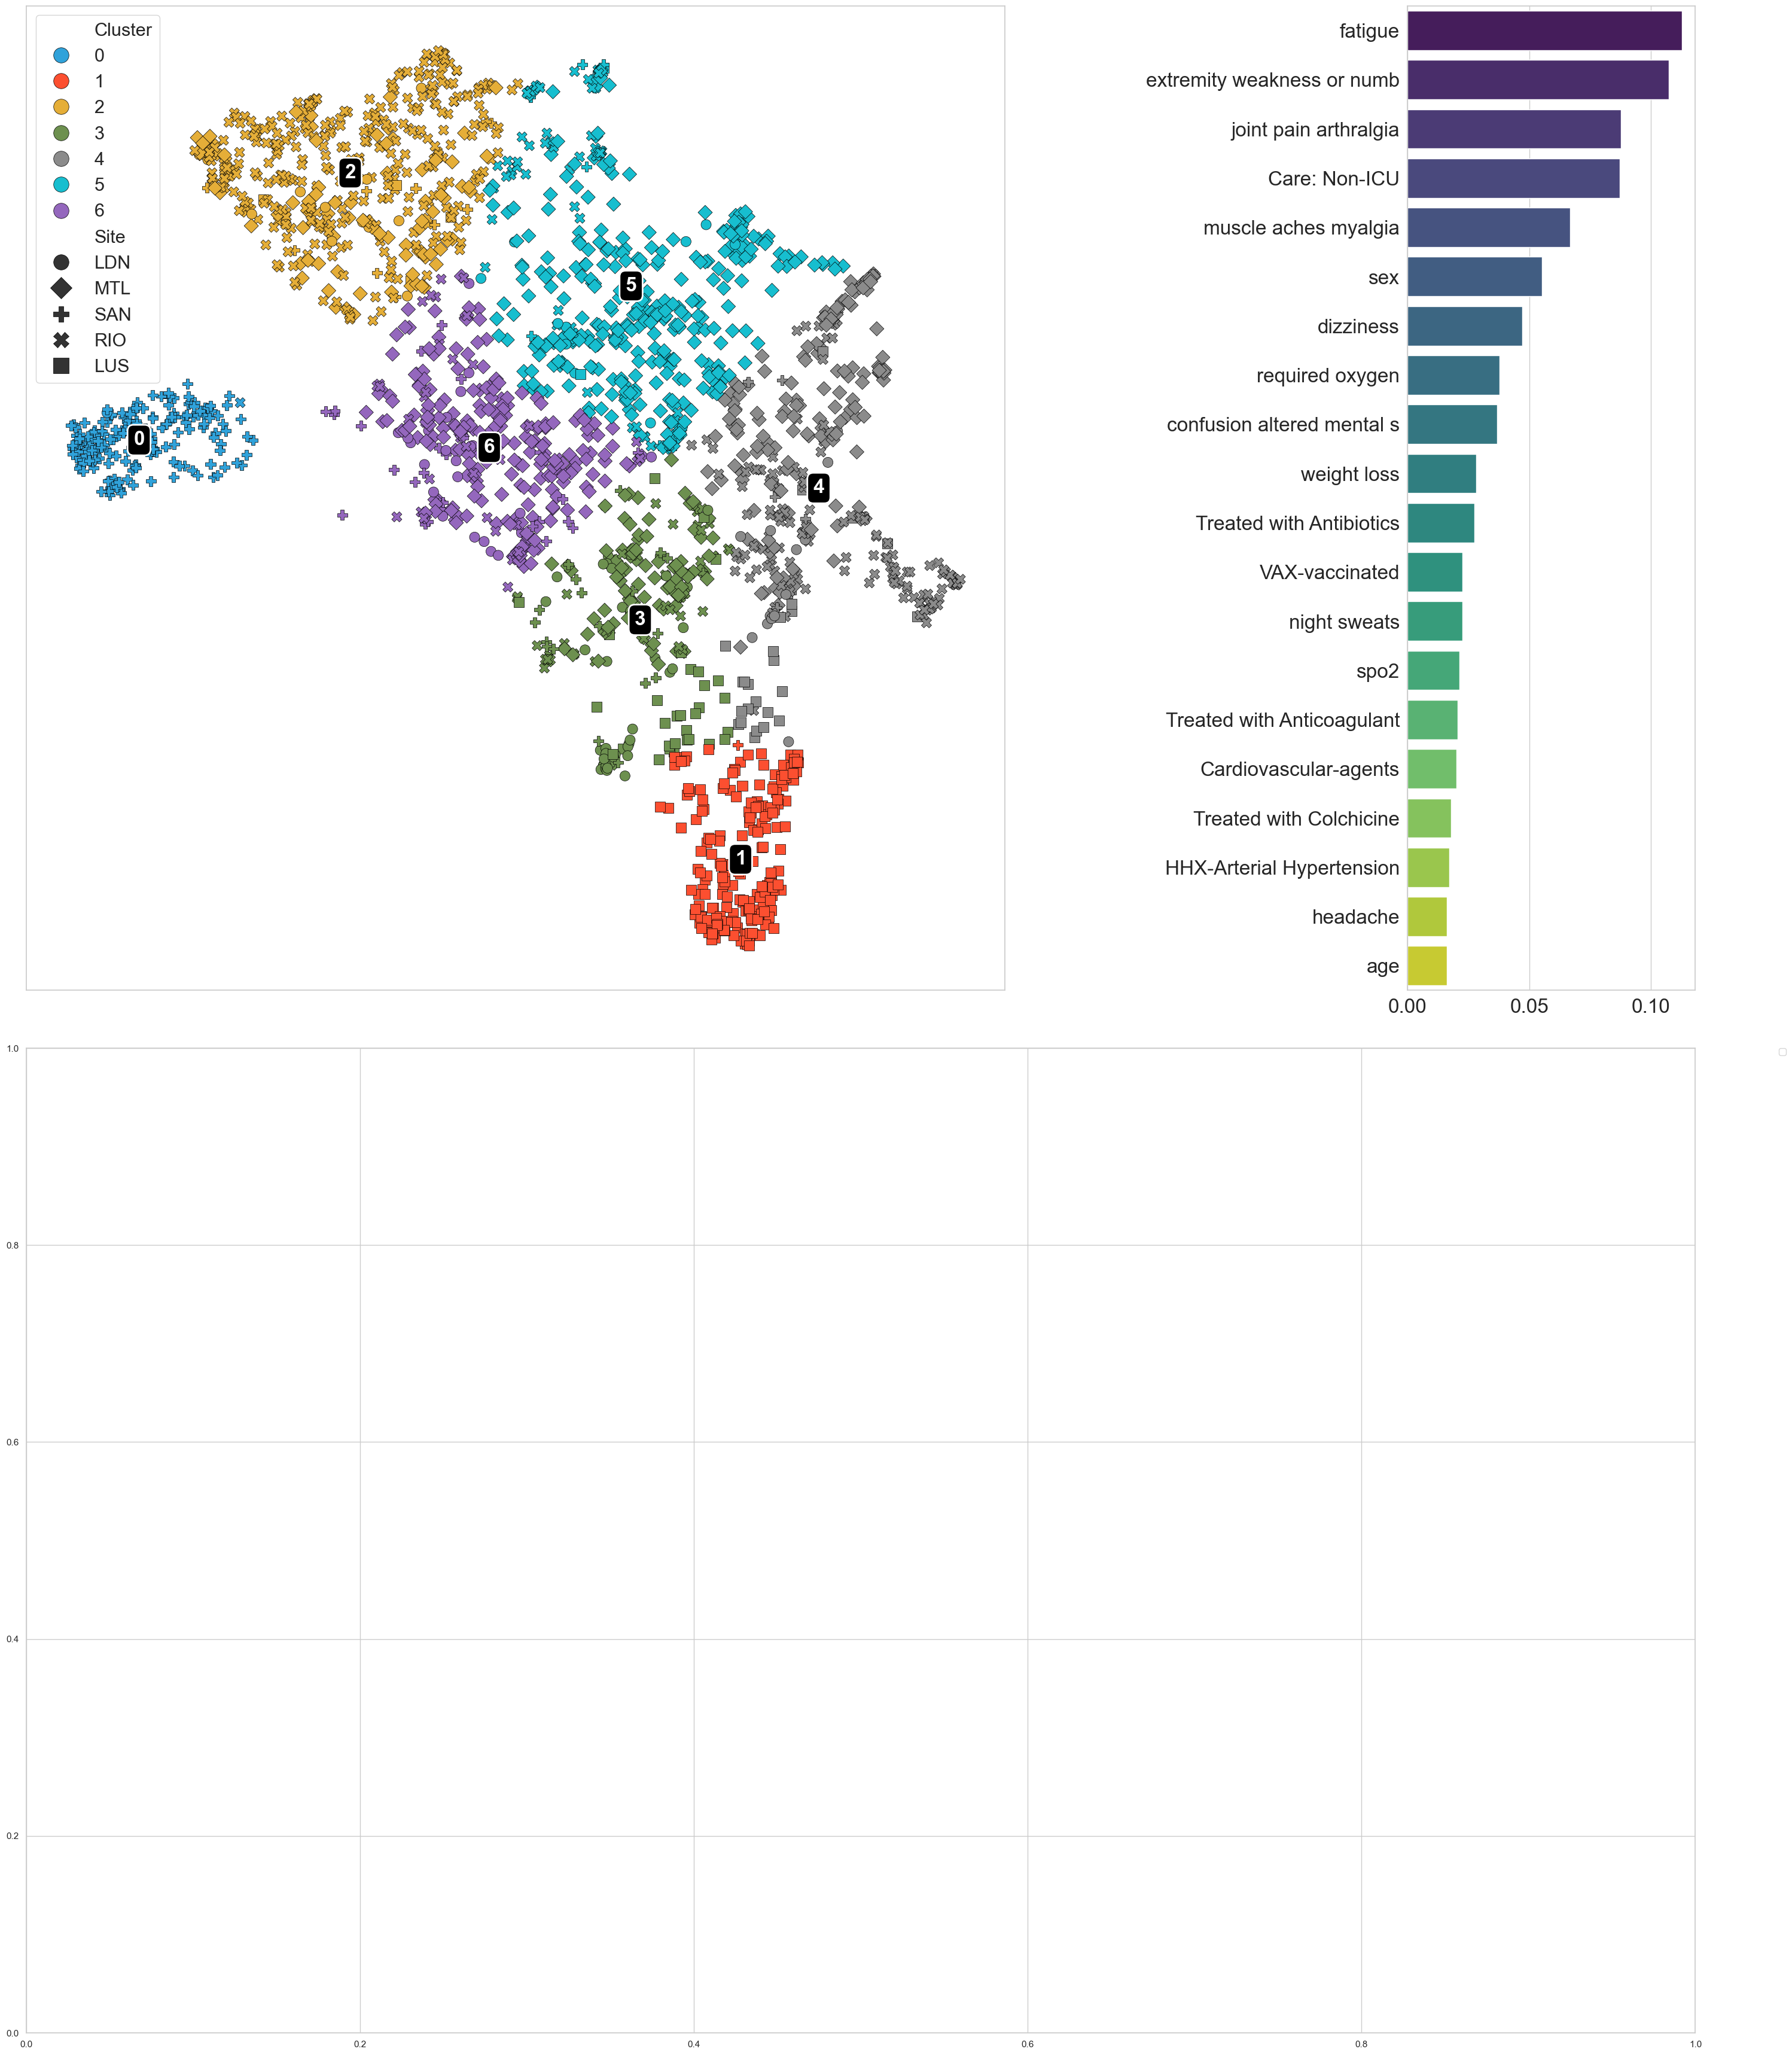

In [70]:

outer_nested_mosaic = [
    ["umap", "umap", "umap","X", "bars"],
    ["umap", "umap", "umap","X", "bars"],
    ["umap", "umap", "umap","X", "bars"],
    ["exc", "exc", "exc","exc", "exc"],
    ["exc", "exc", "exc","exc", "exc"],
    ["exc", "exc", "exc","exc", "exc"],
]


# lower rows
lower_rows = [f"bottom{i}" for i in range(1,11)]

import matplotlib.transforms as mtransforms

# axd = plt.figure(figsize = (36,36)).subplot_mosaic(
#     outer_nested_mosaic, empty_sentinel="X"
# )


fig, axd = plt.subplot_mosaic(outer_nested_mosaic, figsize = (36,44), empty_sentinel="X")

plot_clusters(plot_df, site_name_dict, title = None, centroids = True, size_by_prob = False, ax = axd["umap"])

axd["umap"].set_xticks([]); axd["umap"].set_yticks([]);
# turn off axis labels
axd["umap"].set_xlabel(""); axd["umap"].set_ylabel("")

# make the legend larger
axd["umap"].legend(loc='best',markerscale=1.5, fontsize = FONTSIZE-2)

# adjust bottom spacing
# plt.subplots_adjust(bottom=0.1)
# plt.subplots_adjust(top=0.9)

# second, plot the feature importances
sns.barplot(
                y       = features20["Feature"], 
                x       = features20["Importance"],
                palette = "viridis", 
                hue     = features20["Feature"],
                # orient = "h",
                ax = axd["bars"]
                )

# make the x ticks and label larger
axd["bars"].tick_params(axis='both', which='major', labelsize=FONTSIZE)


# turn off the labels
axd["bars"].set_xlabel(""); axd["bars"].set_ylabel("")
# axd["bars"].yaxis.tick_right()

# set yaxis tick labels to the right of the y-axis spine





# plt.savefig(f"{figdir}/fig-v2.pdf", dpi = 300, bbox_inches = 'tight')
# plt.show()
# plt.close()

### UPSET PLOTS

In [ ]:
A["SITE"] = LC_pos_["SITE"]

In [ ]:
II = pd.DataFrame(scaler.inverse_transform(A.drop(["cluster", "SITE"], axis = 1))) # type: ignore

# get column names and index names from X 
II.columns = X.columns
II.index   = X.index

In [ ]:
# A.shape, X.shape, II.shape
# vv = A.drop("cluster", axis = 1)
B = II.copy()

# augment with site labels
B["SITE"] = LC_pos_["SITE"].map(site_name_dict)

# expand the SITE column to five one-hot encoded columns
# B = pd.concat([B, pd.get_dummies(B["SITE"])], axis = 1)

In [ ]:
# TODO: get the interesting features from the feature selection list above
# TODO: or sort everyting by feature importance, then make the full plots

In [ ]:
interesting = list(g.index[:5])

In [ ]:
interesting = list(fff["Feature"][:5])
interesting

['CD-type_of_care___2',
 'SYMPT-extremity_weakness_or_numb___2',
 'sex',
 'SYMPT-fatigue___2',
 'SYMPT-muscle_aches_myalgia___2']

In [ ]:
upset_A = make_upset_data(A, 
                       interesting, 
                       )

upset_data = make_upset_data(B, 
                                interesting, 
                                keep_features = True
                                )

indicators_bool = upset_data.select_dtypes(include = ['bool'])

In [ ]:
us = UpSet(
    from_indicators(indicators_bool, data = upset_data),
    min_subset_size=15,
    # max_subset_size=200,
    show_counts                = True,
    sort_categories_by         = "-input",
    subset_size                = "count",
    intersection_plot_elements = 0,
    orientation                = "horizontal",
)

# us.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = cc.glasbey_light[0],  linewidth = 3, )

us.add_stacked_bars(by="SITE", 
                       title="Count SITE", 
                       elements=10, 
                       colors = cc.m_glasbey_hv, 
                       )

us.plot()
plt.show()

/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/Users/david/mambaforge/envs/clust/lib/python3.11/site-packages/upsetplot/plotting.py:796: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are settin

In [ ]:
# upset = UpSet(upset_A, 
#                 subset_size = "count", 
#                 orientation = "horizontal", 
#                 sort_categories_by         = "-input",
#                 show_counts = False, 
#                 intersection_plot_elements = 0,
#                 max_subset_size = 200
#                 )
# # upset.style_subsets(present = ">HHX-HIV or AIDS",  edgecolor = "red", linewidth = 3)
# # upset.style_categories(">HHX-HIV or AIDS", shading_facecolor = "blue")

# # upset.add_stacked_bars(by="cluster", title="Count Cluster", elements=5, colors = cc.m_glasbey_hv)


# upset.plot()
# plt.show()

# SUBGROUP: Lusaka

In [ ]:
# # make a df just for Lusaka
# df_lusaka = LC_pos.query('SITE == 5').copy()


# # drop object columns
# # drop columns with dtype = object
# try:
#     df_lusaka = df_lusaka.drop(columns=['LC_STATUS'])

# except:
#     pass

# df_lusaka.info()

# # fill nas with zero
# # df_lusaka.fillna(0, inplace = True)
# df_lusaka.dropna(inplace = True, axis = 1)

# # drop SITE and dag
# d1 = df_lusaka.drop(columns = ['SITE'])

In [ ]:
# # sklearn pipelines
# import sklearn.cluster as cluster
# from sklearn.pipeline import Pipeline

# # instantiate the pipeline
# hdb_parms['min_cluster_size'] = int(np.sqrt(d1.shape[0]))

# pipe = Pipeline([
#                 ('scale', MinMaxScaler()),
#                 ('embed', UMAP(**umap_parms, verbose = True)),
#                 # ('embed', tsne_transformer),
#                 # ('cluster', cluster.HDBSCAN(min_cluster_size = min_cluster_size)),
#                 ('cluster', HDBSCAN(prediction_data = True)),

#                 ])

# # apply to the lusaka dataframe
# pipe.fit(d1)

# # check the version of the embed object

# if isinstance(pipe.steps[1][1], UMAP):
#     points   = pipe["embed"].embedding_
# elif isinstance(pipe.steps[1][1], FunctionTransformer):
#     points   = pipe["embed"].transform(d1)
# else:
#     print(f"Something went wrong - {pipe.steps[1][1]}")

# clusters = pipe["cluster"].labels_
# probs    = pipe["cluster"].probabilities_
# sites    = LC_pos_.loc[X.index]["SITE"].map(site_name_dict)

# # # cluster labels are the maximally probable cluster
# cluster_labels = np.argmax(all_points_membership_vectors(pipe["cluster"]), 
#                            axis = 1)

# clusters = cluster_labels

# # plot it
# # sns.scatterplot(x = points[:,0], y = points[:,1], hue = clusters, palette = palette_dict, size = list(probs*100), linewidth = 0.5, edgecolor = 'black')

In [ ]:
# d1.shape, df_lusaka.shape
# len(points)
# plot_df = pd.DataFrame(points, columns = ["x", "y"], index = df_lusaka.index)
# plot_df["Cluster"] = clusters
# plot_df["Cluster Confidence"] = probs
# plot_df["Site"] = df_lusaka["SITE"].map(site_name_dict)

# # what fraction of the data is in each cluster?
# plot_df["Cluster"].value_counts(normalize = True)*100

# plot_clusters(plot_df, site_name_dict, title = f"UMAP + HDBSCAN Clustering - Lusaka")
# # use a random forest classifier to find the most important features
# from sklearn.ensemble import RandomForestClassifier

# # instantiate the classifier
# rf = RandomForestClassifier(n_estimators = 1_000, max_depth = 5, random_state = 42)

# X = df_lusaka

# # fit the classifier

# rf.fit(X, cluster_labels)
# # get the 10 most important features
# importances = rf.feature_importances_

# indices = np.argsort(importances)[::-1][:10]

# # get the feature names
# features = X.columns

# # plot the feature importances
# plt.figure(figsize=(10, 6))

# plt.title("Feature importances")

# sns.barplot(x = importances[indices], y = features[indices], palette = "viridis")